<a href="https://colab.research.google.com/github/jfgf11/Examen-2-Machine/blob/master/examen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Examen 2




In [1]:
#Se monta el Drive para importar y guardar los datos y modelos.
from google.colab import drive
drive.mount('/content/drive')#,force_remount = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Instalación

In [2]:
#Se instalan las librerías que se necesitan.
!pip install pyEDFlib
!pip install progressbar2
!pip install matplotlib --upgrade
!pip install h5py

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.1.2)


#Librerías

In [0]:
#Se importan las librerías requeridas.
#Se deben primero instalar las librerías que hacen falta con la celda en la
#sección de Instalación.
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Model
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

import pandas as pd
import pyedflib as pyedf
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import seaborn as sns
import progressbar
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

import itertools

#Clases

In [0]:
#Esta no esta terminada.

#Clase utilizada para presentar los resultados de los modelos.
#En esta se incluyen una gráfica de la historia de entrenamiento y validación,
#
class Resultados:
    def __init__(self, p_y_pred, p_y_true, pHist):
        self.y_pred = p_y_pred
        self.y_true = p_y_true
        self.hist = pHist

    def convertirClases(self):
      #Esto depronto no lo vamos a usar.
      self.y_pred_convertidos = ((self.y_pred == 1) + (self.y_pred == 2)) + 2*((self.y_pred == 3) + (self.y_pred == 4)) + 3*(self.y_pred == 5)
      self.y_true_convertidos = ((self.y_true == 1) + (self.y_true == 2)) + 2*((self.y_true == 3) + (self.y_true == 4)) + 3*(self.y_true == 5)

    def darEtiqueta(self, pEstadoSueno):
      et = 0

      if(pEstadoSueno == "Sleep stage 1"):
        et = 1
      elif(pEstadoSueno == "Sleep stage 2"):
        et = 2
      elif(pEstadoSueno == "Sleep stage 3"):
        et = 3
      elif(pEstadoSueno == "Sleep stage 4"):
        et = 4
      elif(pEstadoSueno == "Sleep stage R"):
        et = 5
      else:
        print("Primero eliminar la clase desconocida.")
      
      return et
      
    def darEstadosSueno(self, pEtiquetas):
      estados = pEtiquetas 

      estados[estados == 0] = "Despierto"
      estados[estados == 1] = "Sueño ligero"
      estados[estados == 2] = "Sueño profundo"
      estados[estados == 3] = "Sueño REM"
      
      return estados

    def graficarMatrizConfusion(self):
      cm = confusion_matrix(self.y_true, self.y_pred)#, self.labels)
      #print(cm)
      #estados = self.darEstadosSueno(np.array([0, 1, 2, 3]))
      
      ax = sns.heatmap(cm, annot = True, cbar = False); #annot=True to annotate cells
      
      #plt.ylim()
      #plt.ylim(bottom = 3.5, top = -0.5)
      ax.xaxis.tick_top()
      plt.xlabel("Clase Prediccion")
      plt.ylabel("Clase Verdadera")
      plt.title("Matriz de Confusion")

      plt.show()


    def graficarNoches(self, pPred, pTrue):
      tiempo = np.arange(0, len(pPred)*30, 30)
      estados = darEstadosSueno(np.array([0, 1, 2, 3]))

      plt.plot(tiempo, pPred, label = "Predicciones Modelo")
      plt.plot(tiempo, pTrue, label = "Etiquetas Experto")
      plt.set_yticklabels(estados)
      plt.xlabel("Tiempo (s)")
      plt.ylabel("Estado de Sueño")
      plt.title("Estado del Sueño en una Noche")

      plt.show()

    def graficarHistoria(self):
      plt.plot(self.hist.history['sparse_categorical_accuracy'], label = 'Accuracy Entrenamiento')
      plt.plot(self.hist.history['val_sparse_categorical_accuracy'], label = 'Accuracy Validacion')
      plt.xlabel('Epoca')
      plt.ylabel('Accuracy')
      plt.title("Accuracy vs Epoca")
      plt.legend()
      plt.show()

    def calcularError(self):
      error = np.sum(self.y_pred_convertidos != self.y_true_convertidos)
      error = error/len(self.y_pred_convertidos)

      return error

    def calcularF1(self):
      f1 = f1_score(self.y_true, self.y_pred, average = 'micro')
      return f1

    def calcularPrecision(self):
      precision = precision_score(self.y_true, self.y_pred, average = 'micro')
      return precision

    def calcularRecall(self):
      recall = recall_score(self.y_true, self.y_pred, average = 'micro')
      return recall


#Lectura de los Datos

In [2]:
rutaDatos = "drive/My Drive/DatosExamen2/processed"

def importarDatos():
  datos = np.zeros((1,3000, 3))
  etiquetas = np.zeros(1)

  p = 0

  with progressbar.ProgressBar(max_value = 9) as bar:
    for i in range(0,1):
        for j in range(0,9):
          if i == 1 and j == 0:
            datos = datos[1:len(datos)]
            etiquetas = etiquetas[1:len(etiquetas)]
            return datos, etiquetas

          numInferior = str(i) + str(j) + "0"
          numSuperior = str(i) + str(j) + "9"

          temp1 = np.load(rutaDatos + "/DatosCompletos_" + numInferior  + "_" + numSuperior + ".npy")
          temp2 = np.load(rutaDatos + "/Etiquetas_" + numInferior +  "_" + numSuperior + ".npy")

          datos = np.vstack((datos, temp1))
          etiquetas = np.append(etiquetas, temp2)

          p+=1
          bar.update(p)
        

  datos = datos[1:len(datos)]
  etiquetas = etiquetas[1:len(etiquetas)]
  
  return datos, etiquetas

unosDatos, unosEtiquetas = importarDatos()

100% (9 of 9) |##########################| Elapsed Time: 0:00:37 Time:  0:00:37


In [0]:
#Para cargar los datos totales
unosDatos = np.load("drive/My Drive/DatosExamen2/processed/DatosTotales_0_149.npy")
unosEtiquetas = np.load("drive/My Drive/DatosExamen2/processed/EtiquetasTotales_0_149.npy")
# unosDatos = np.load("drive/My Drive/DatosExamen2/processed/DatosCompletos_010_019.npy")
# unosEtiquetas = np.load("drive/My Drive/DatosExamen2/processed/Etiquetas_010_019.npy")
#np.save("drive/My Drive/DatosExamen2/processed/DatosTotales_0_149", unosDatos)
#np.save("drive/My Drive/DatosExamen2/processed/EtiquetasTotales_0_149", unosEtiquetas)

In [0]:
filenameDatos = "drive/My Drive/sleep-cassette"
filenameDescripcion = "drive/My Drive/SC-subjects.xls"

ArchivoLightsOff=pd.read_excel(filenameDescripcion, sheet_name='Blad1')

TiempoLightsOff=ArchivoLightsOff["LightsOff"].values
TiempoLightsOffSegundos=TiempoLightsOff
HorasSuenio=8

for i in range (0, len(TiempoLightsOff)):
  segundos=int(TiempoLightsOff[i].hour) * 3600 + int(TiempoLightsOff[i].minute) * 60
  TiempoLightsOffSegundos[i]=segundos

listaArchivos = os.listdir(filenameDatos)

listaHypnograms = [i for i in listaArchivos if "Hypnogram" in i] 
listaPSGs = [i for i in listaArchivos if "PSG" in i]

listaHypnograms.sort()
listaPSGs.sort()

print("Importando datos...")

start = time.time()

Datos1=np.zeros(3000)
Datos2=np.zeros(3000)
Datos3=np.zeros(3000)

Etiquetas=[0]

p = 0
inicioNumArchivos =10
numArchivos = 10

with progressbar.ProgressBar(max_value=numArchivos*960) as bar:
  for i in range(inicioNumArchivos,inicioNumArchivos+numArchivos):#len(listaHypnograms)):

    hyp = listaHypnograms[i]
    psg = listaPSGs[i]

    print("Hyp: {}, PSG: {}".format(hyp,psg))

    fileHyp = pyedf.EdfReader(filenameDatos + "/" + hyp)
    filePSG = pyedf.EdfReader(filenameDatos + "/" + psg)

    hypTime, hypDur, hypEtiqueta = fileHyp.readAnnotations()

    tiempoComienzo = fileHyp.starttime_hour*3600+fileHyp.starttime_minute*60+fileHyp.starttime_second
    offset=TiempoLightsOffSegundos[i]-tiempoComienzo
    if offset<0:
      offset+=24*3600
    LimiteSuperior=offset+HorasSuenio*3600
    ventana=30
    tiempo=offset
    j=0
    referenciaSenial=0
    FrecuenciaMuestreo = filePSG.getSampleFrequency(referenciaSenial)

    while tiempo<LimiteSuperior:
      if tiempo>hypTime[j]:
        j+=1
        
      ventanaMuestra = np.round(FrecuenciaMuestreo * ventana)
      muestraInicial = np.round(FrecuenciaMuestreo * tiempo)
      senial1=filePSG.readSignal(0)
      senial2=filePSG.readSignal(1)
      senial3=filePSG.readSignal(2)
      senialActual1=senial1[muestraInicial:muestraInicial+ventanaMuestra]
      senialActual2=senial2[muestraInicial:muestraInicial+ventanaMuestra]
      senialActual3=senial3[muestraInicial:muestraInicial+ventanaMuestra]
      
      etiquetaActual=hypEtiqueta[j]
      
      Datos1=np.vstack((Datos1,senialActual1))
      Datos2=np.vstack((Datos2,senialActual2))
      Datos3=np.vstack((Datos3,senialActual3))

      Etiquetas=np.vstack((Etiquetas,etiquetaActual))
      tiempo+=ventana
      p+=1
      bar.update(p)

    fileHyp._close() 
    filePSG._close()
#print(listaHypnograms)
#print(listaPSGs)

print("Termino.")
print("Tiempo: {} segundos.".format(time.time()-start))

Importando datos...
Hyp: SC4051EC-Hypnogram.edf, PSG: SC4051E0-PSG.edf


 10% (960 of 9600) |##                   | Elapsed Time: 0:21:33 ETA:   3:14:40

Hyp: SC4052EC-Hypnogram.edf, PSG: SC4052E0-PSG.edf


 20% (1920 of 9600) |####                | Elapsed Time: 0:44:00 ETA:   2:56:17

Hyp: SC4061EC-Hypnogram.edf, PSG: SC4061E0-PSG.edf


 30% (2880 of 9600) |######              | Elapsed Time: 1:06:09 ETA:   2:32:11

Hyp: SC4062EC-Hypnogram.edf, PSG: SC4062E0-PSG.edf


 40% (3840 of 9600) |########            | Elapsed Time: 1:28:43 ETA:   2:16:06

Hyp: SC4071EC-Hypnogram.edf, PSG: SC4071E0-PSG.edf


 50% (4800 of 9600) |##########          | Elapsed Time: 1:51:22 ETA:   1:52:49

Hyp: SC4072EH-Hypnogram.edf, PSG: SC4072E0-PSG.edf


 60% (5760 of 9600) |############        | Elapsed Time: 2:14:17 ETA:   1:31:07

Hyp: SC4081EC-Hypnogram.edf, PSG: SC4081E0-PSG.edf


 70% (6720 of 9600) |##############      | Elapsed Time: 2:37:42 ETA:   1:10:18

Hyp: SC4082EP-Hypnogram.edf, PSG: SC4082E0-PSG.edf


 80% (7680 of 9600) |################    | Elapsed Time: 2:59:58 ETA:   0:45:02

Hyp: SC4091EC-Hypnogram.edf, PSG: SC4091E0-PSG.edf


 90% (8640 of 9600) |##################  | Elapsed Time: 3:23:06 ETA:   0:23:05

Hyp: SC4092EC-Hypnogram.edf, PSG: SC4092E0-PSG.edf


100% (9600 of 9600) |####################| Elapsed Time: 3:47:30 Time:  3:47:30


Termino.
Tiempo: 13654.461708545685 segundos.


In [0]:
def appendDatos(pDatos1, pDatos2, pDatos3):
  Datos_Generales=np.zeros((pDatos1.shape[0],3000,3))

  for i in progressbar.progressbar(range(0,pDatos1.shape[0])):

    Datos_Generales[i,:,0]=pDatos1[i]
    Datos_Generales[i,:,1]=pDatos2[i]
    Datos_Generales[i,:,2]=pDatos3[i]
    
  return Datos_Generales

In [0]:
#Esto solo se corre una vez.
#Etiquetas = Etiquetas[1:len(Etiquetas)]
#Datos1 = Datos1[1:Datos1.shape[0]]
#Datos2 = Datos2[1:Datos2.shape[0]]
#Datos3 = Datos3[1:Datos3.shape[0]]

(62592, 3000, 3)

In [0]:
numArchivos = 10

def darEtiqueta(pEtiqueta):
  et = 0

  if(pEtiqueta == "Sleep stage 1"):
    et = 1
  elif(pEtiqueta == "Sleep stage 2"):
    et = 2
  elif(pEtiqueta == "Sleep stage 3"):
    et = 3
  elif(pEtiqueta == "Sleep stage 4"):
    et = 4
  elif(pEtiqueta == "Sleep stage R"):
    et = 5
  else:
    print("Primero eliminar la clase desconocida.")
  
  return et
  
def darEstadoSueno(pEtiqueta):
  estado = "Despierto"

  if(pEtiqueta == 1):
    estado = "Sueño ligero"
  elif(pEtiqueta == 2):
    estado = "Sueño profundo"
  elif(pEtiqueta == 3):
    estado = "Sueño REM"
  else:
    print("Primero eliminar la clase desconocida.")
  
  return estado

def eliminarClaseDesconocida(pDatos, pEtiquetas):
  et = []
  dat = np.zeros(3000)

  with progressbar.ProgressBar(max_value=numArchivos*960) as bar:
    for i in range(0, len(pEtiquetas)):
      bar.update(i)
      if pEtiquetas[i] != 'Sleep stage ?':
        
        if pEtiquetas[i]=="Sleep stage W":
          et = np.append(et,0)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage 1":
          et = np.append(et,1)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage 2":
          et = np.append(et,2)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage 3":
          et = np.append(et,3)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage 4":
          et = np.append(et,4)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage R":
          et = np.append(et,5)
          dat = np.vstack((dat, pDatos[i,:]))
        else:
          pass
          #print("Hay una clase distinta a las definidas.")

  dat = dat[1:dat.shape[0]]
  return dat, et
#print(Datos1.shape)
#Datos1, Etiquetas1 = eliminarClaseDesconocida(Datos1, Etiquetas)
#Datos2, Etiquetas2 = eliminarClaseDesconocida(Datos2, Etiquetas)
#Datos3, Etiquetas3 = eliminarClaseDesconocida(Datos3, Etiquetas)
#print(Datos1.shape)
#np.save("Datos", unosDatos)
#np.save("Etiquetas", unosEtiquetas)

#print(len(unosEtiquetas))
#print(len(unosDatos))

#Preparación de Datos

In [0]:
#Probar under y over sampling
smote = SMOTE(ratio = 'not majority', k_neighbors = 3)
smotetomek = SMOTETomek(ratio = 'not majority')
randomOverSampler = RandomOverSampler(sampling_strategy = 'not majority')

In [0]:
def convertirClases(pY):
      y = ((pY == 1) + (pY == 2)) + 2*((pY == 3) + (pY == 4)) + 3*(pY == 5)
      #y = pY==1
      return y

#x_train = np.expand_dims(np.transpose(x_train), axis=3) # reshape (569, 30) to (569, 30, 1) 
#x_test = np.expand_dims(np.transpose(x_test), axis=3) # reshape (569, 30) to (569, 30, 1) 

In [0]:
unosEtiquetas = convertirClases(unosEtiquetas)

In [25]:
print("Separando datos en entrenamiento y validacion...")

x_train, x_test, y_train, y_test = train_test_split(unosDatos, unosEtiquetas , random_state = 0, test_size=0.10)
# x_train, x_test, y_train, y_test = train_test_split(unosDatos, unosEtiquetas , random_state = 0, test_size=0.20)

print(x_train.shape)

unosDatos = None
unosEtiquetas = None

Separando datos en entrenamiento y validacion...
(122006, 3000, 3)


In [0]:
x_train = np.reshape(x_train, (-1, 9000),'F')

print("Oversampling...")

# x_train, y_train = smote.fit_resample(x_train, y_train)
x_train, y_train = randomOverSampler.fit_resample(x_train, y_train)

print("Reshaping...")

x_train = np.reshape(x_train, (-1, 3000, 3), 'F')

print(x_train.shape)

#print(x_test[0,0:5,0])
#print(test[0,0:5])

In [0]:
#Para obtener los pesos de cada clase
pesosClases = compute_class_weight(class_weight = 'balanced', classes = np.array([0, 1, 2, 3]), y = unosEtiquetas)

pesosClases = {0: pesosClases[0],
               1: pesosClases[1],
               2: pesosClases[2],
               3: pesosClases[3]}

In [30]:
pesosClases

{0: 1.3677206505508697,
 1: 0.4791227822153107,
 2: 1.1912390158172232,
 3: 2.921868264505561}

In [16]:
def encontrarCantidadClase(pEtiquetas, pClase):
  return np.sum(pEtiquetas == pClase)

for i in range(0,4):  
  print(encontrarCantidadClase(unosEtiquetas, i))

24779
70735
28450
11599


In [0]:
np.save("drive/My Drive/DatosExamen2/processed/DatosOversample_x_train", x_train)
np.save("drive/My Drive/DatosExamen2/processed/DatosOversample_y_train", y_train)
np.save("drive/My Drive/DatosExamen2/processed/DatosOversample_x_test", x_test)
np.save("drive/My Drive/DatosExamen2/processed/DatosOversample_y_test", y_test)

#Entrenamiento del Modelo

In [0]:
#unosEtiquetas=np.load("drive/My Drive/Etiquetas.npy")
#unosDatos=np.load("drive/My Drive/Datos.npy")
#np.save("drive/My Drive/Datos_Generales_10_19", Datos_Generales_10_19)
#np.save("drive/My Drive/Etiquetas", unosEtiquetas)
#np.save("drive/My Drive/Etiquetas_10_19", Etiquetas)
#Datos1_10_19=Datos1
#Datos2_10_19=Datos2
#Datos3_10_19=Datos3

#np.save("drive/My Drive/Datos1_10_19.npy",Datos1_10_19)
#np.save("drive/My Drive/Datos2_10_19.npy",Datos2_10_19)
#np.save("drive/My Drive/Datos3_10_19.npy",Datos3_10_19)

#Datos1, unosEtiquetas = eliminarClaseDesconocida(Datos1, unosEtiquetas)

#unosDatos = appendDatos(Datos1, Datos2, Datos3)
#np.save("drive/My Drive/DatosCompletos.npy", unosDatos)

#unosDatos = np.load("drive/My Drive/DatosTotales_0_119.npy")
#unosEtiquetas=np.load("drive/My Drive/Etiqueta_0_119.npy")

#Implementación en Keras

Se separan los datos de entrenamiento y validación

Creación del modelo

In [0]:
#Numero de clases
numClases = 4

def crearModelo(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):
  modelo = Sequential()

  #Esto corresponderia a la parte convolucional.
  modelo.add(Conv1D(pNumFiltros[0], int(pTamFiltros[0]), activation = 'relu', input_shape = (3000,3)))
  modelo.add(Conv1D(pNumFiltros[1], int(pTamFiltros[1]), activation = 'relu'))
  modelo.add(MaxPooling1D(int(pTamPooling[0])))
  
  modelo.add(Conv1D(pNumFiltros[2], int(pTamFiltros[2]), activation = 'relu'))
  modelo.add(Conv1D(pNumFiltros[3], int(pTamFiltros[3]), activation = 'relu'))
  modelo.add(AveragePooling1D(int(pTamPooling[1])))

 
  modelo.add(GlobalAveragePooling1D())
  #modelo.add(MaxPooling1D(int(pTamPooling[2])))
  modelo.add(Flatten())

  #Esto corresponderia a la parte de red neuronal normalita. (Puse cualquier cosa por ahora)
  #modelo.add(Dropout(0.5))
  #modelo.add(Dense(pNumNeuronas[0], activation = 'relu'))
 
  
  modelo.add(Dense(pNumNeuronas[1], activation = 'relu'))#, activity_regularizer=l2(pAlpha)))
  modelo.add(Dense(pNumNeuronas[2], activation = 'relu', activity_regularizer=l2(pAlpha)))
  #modelo.add(Dense(pNumNeuronas[3], activation = 'relu', activity_regularizer=l2(pAlpha)))

  modelo.add(Dense(numClases, activation = 'softmax'))#, activity_regularizer = l2(pAlpha)))
  
  
  #modelo.add(Dense(numClases, activation = 'softmax'))

  sgd = optimizers.SGD(lr = pTasa, momentum=0.9)
  adam = optimizers.Adam(learning_rate = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  modelo.summary()

  return modelo

def crearModelo2(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):

  capaEntrada = Input(shape = (3000,3))
  # pooling0 = MaxPooling1D(int(pTamPooling[0]), padding='same')(capaEntrada)
  # pooling0 = Reshape((-1, int(pNumFiltros[0])))(pooling0)
  
  capa1 = Conv1D(pNumFiltros[0], int(pTamFiltros[0]), padding='same', activation = 'relu')(capaEntrada)
  pooling1 = MaxPooling1D(int(pTamPooling[1]), padding='same')(capa1)

  capa2 = Conv1D(pNumFiltros[1], int(pTamFiltros[1]), padding='same', activation='relu')(capa1)
  pooling2 = MaxPooling1D(int(pTamPooling[2]), padding='same')(capa2)

  capa3 = Conv1D(pNumFiltros[2], int(pTamFiltros[2]), padding='same', activation='relu')(capa2)
  pooling3 = MaxPooling1D(int(pTamPooling[3]), padding='same')(capa3)

  capas = concatenate([pooling1, pooling2, pooling3], axis=1)
  #capas = Flatten()(capas)
  capas = GlobalAveragePooling1D()(capas)
  #capas = GlobalMaxPooling1D()(capas)
  #capas = Dropout(0.5)(capas)

  #capa4 = LSTM(pNumNeuronas[0])(capas)
  
  #capa4 = Dense(pNumNeuronas[0], activation='relu')(capas)
  #capaSalida = Dense(numClases, activation='softmax')(capaSalida)
  capaSalida = Dense(numClases, activation='softmax')(capas)

  modelo = Sequential()
  modelo.add(Model(capaEntrada, capaSalida))

  sgd = optimizers.SGD(lr = pTasa)#, momentum=0.9)
  adam = optimizers.Adam(learning_rate = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  modelo.layers[0].summary()
  
  return modelo

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3000, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 3000, 80)     800         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 3000, 80)     64080       conv1d_3[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 3000, 80)     192080      conv1d_4[0][0]                   
____________________________________________________________________________________________

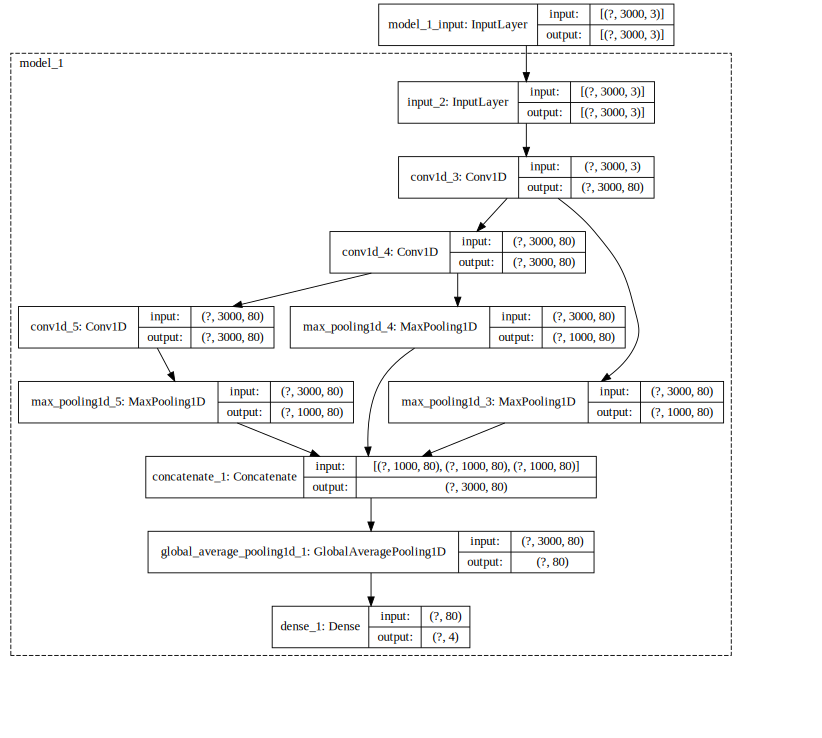

In [28]:
numFiltros = np.array([80, 80, 80, 80, 5, 5])
tamFiltros = np.array([3, 10, 30, 10, 10, 10])
tamPooling = np.array([3, 3, 3, 3])
optimizer="sgd"
numNeuronas = np.array([15, 20, 10])

tasa = 0.001
alpha = 0.01

modelo = crearModelo2(tasa, alpha, numFiltros, tamFiltros, tamPooling, numNeuronas, optimizer)

#Esta linea muestra un diagrama de la red neuronal.
SVG(model_to_dot(modelo, show_shapes = True, expand_nested = True, dpi = 65).create(prog='dot', format='svg'))

In [0]:
epocas = 2000
batchSize = 512
# hist = modelo.fit(x_train, y_train, verbose = 1, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize)
hist = modelo.fit(x_train, y_train, verbose = 1, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize, class_weight = pesosClases)

resultadosEntrenamiento = Resultados(y_train, modelo.predict_classes(x_train), hist)
resultadosValidacion = Resultados(y_test, modelo.predict_classes(x_test), hist)

resultadosEntrenamiento.graficarHistoria()

print(resultadosEntrenamiento.graficarMatrizConfusion())
print(resultadosValidacion.graficarMatrizConfusion())

print("\nEstadisticas de Entrenamiento")
print("------------------------------")
print("Precision: {}".format(resultadosEntrenamiento.calcularPrecision()))
print("Recall: {}".format(resultadosEntrenamiento.calcularRecall()))
print("F1: {}".format(resultadosEntrenamiento.calcularF1()))

print("\nEstadisticas de Validacion")
print("------------------------------")
print("Precision: {}".format(resultadosValidacion.calcularPrecision()))
print("Recall: {}".format(resultadosValidacion.calcularRecall()))
print("F1: {}".format(resultadosValidacion.calcularF1()))

Train on 122006 samples, validate on 13557 samples
Epoch 1/2000
109568/122006 [=========================>....] - ETA: 11s - loss: 1.3788 - sparse_categorical_accuracy: 0.3595

In [0]:
def guardarModelo(pModelo):
  modelo_json = pModelo.to_json()

  with open("drive/My Drive/ModelosExamen2/Modelo.json", "w") as archivo_json:
      archivo_json.write(modelo_json)

  pModelo.save_weights("drive/My Drive/ModelosExamen2/PesosModelo.h5")

  plot_model(pModelo, to_file = "drive/My Drive/ModelosExamen2/Modelo.png", show_shapes = True)

def cargarModelo(pRutaModelo, pRutaPesos):
  archivo_json = open(pRutaModelo, 'r')
  modelo_json = archivo_json.read()
  archivo_json.close()
  modelo = model_from_json(modelo_json)

  modelo.load_weights(pRutaPesos)

  return modelo

In [0]:
rutaModelo = "drive/My Drive/ModelosExamen2/ModeloOver.json"
rutaPesos = "drive/My Drive/ModelosExamen2/PesosModeloOver.h5"

In [0]:
guardarModelo(modelo)

In [0]:
modeloCargado = cargarModelo(rutaModelo, rutaPesos)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
numFiltros = np.array([100, 50, 20])
tamFiltros = np.array([6, 6, 6])
tamPooling = np.array([6, 6, 6])
optimizer="adam"
numNeuronas = np.array([10, 8, 6])

parametros = dict(batch_size = [30],
               epochs = [5],
               pOptimizer = ["adam", "sgd"],#,"rmsprop"],
               pTasa = [0.01],
               pAlphas = [0.001],
               pNumFiltros = [numFiltros],
              pTamFiltros = [tamFiltros],
              pTamPooling = [tamPooling],
              pNumNeuronas = [numNeuronas]
              )

In [0]:
def GridSearch(pXtrain, pYtrain, pXtest, pYtest, pParameters):
  i=0
  parameters = []
  bestScore = 0
  bestModel=None
  bestHist = None
  contador=0
  for k in parametros.keys():
    parameters.append(pParameters.get(k))
  with progressbar.ProgressBar(max_value=len(list(itertools.product(*parameters)))) as bar:
    for p in itertools.product(*parameters):
      contador=+1
      bar.update(contador)
      modelo=crearModelo(p[3],p[4],p[5],p[6],p[7],p[8], p[2])
      hist = modelo.fit(pXtrain, pYtrain, verbose = 1, validation_data=(pXtest, pYtest), epochs = p[1], batch_size = p[0])
      l, score =modelo.evaluate(pXtest,pYtest)
      if score>bestScore:
        bestScore = score
        bestModel = modelo
        bestHist = hist
  return bestScore, bestModel, bestHist

N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Train on 7977 samples, validate on 887 samples
Epoch 1/5
7977/7977 [==============================] - 3s 361us/sample - loss: 1.6520 - sparse_categorical_accuracy: 0.3236 - val_loss: 1.6377 - val_sparse_categorical_accuracy: 0.2954
Epoch 2/5
7977/7977 [==============================] - 2s 302us/sample - loss: 1.6042 - sparse_categorical_accuracy: 0.3412 - val_loss: 1.6478 - val_sparse_categorical_accuracy: 0.2954
Epoch 3/5
7977/7977 [==============================] - 2s 304us/sample - loss: 1.6057 - sparse_categorical_accuracy: 0.3421 - val_loss: 1.6405 - val_sparse_categorical_accuracy: 0.2954
Epoch 4/5
7977/7977 [==============================] - 2s 305us/sample - loss: 1.6134 - sparse_categorical_accuracy: 0.3273 - val_loss: 1.6373 - val_sparse_categorical_accuracy: 0.2954
Epoch 5/5
887/887 [==============================] - 0s 143us/sample - loss: 1.6402 - sparse_categorical_accuracy: 0.2954


 50% (1 of 2) |#############             | Elapsed Time: 0:00:13 ETA:   0:00:13

Train on 7977 samples, validate on 887 samples
Epoch 1/5
7977/7977 [==============================] - 3s 349us/sample - loss: 1.6346 - sparse_categorical_accuracy: 0.3383 - val_loss: 1.6308 - val_sparse_categorical_accuracy: 0.2965
Epoch 2/5
7977/7977 [==============================] - 2s 306us/sample - loss: 1.5496 - sparse_categorical_accuracy: 0.3894 - val_loss: 1.5556 - val_sparse_categorical_accuracy: 0.3901
Epoch 3/5
7977/7977 [==============================] - 2s 302us/sample - loss: 1.4849 - sparse_categorical_accuracy: 0.4159 - val_loss: 1.5129 - val_sparse_categorical_accuracy: 0.3890
Epoch 4/5
7977/7977 [==============================] - 2s 303us/sample - loss: 1.4540 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.4913 - val_sparse_categorical_accuracy: 0.4002
Epoch 5/5
887/887 [==============================] - 0s 144us/sample - loss: 1.4619 - sparse_categorical_accuracy: 0.4036


100% (2 of 2) |##########################| Elapsed Time: 0:00:27 Time:  0:00:27


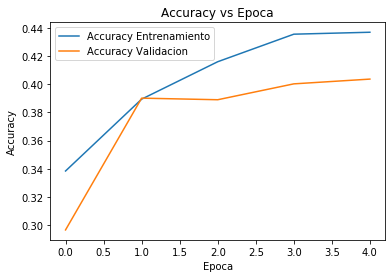

In [0]:
bestScore, bestModel, bestHist = GridSearch(x_train,y_train,x_test,y_test,parametros)
graficarHistoria(bestHist)

#Resultados

In [28]:
resultadosEntrenamiento.calcularF1Micro()

0.5143608748883227

In [0]:
y_pred_train = modeloCargado.predict_classes(x_train)
y_pred_test = modeloCargado.predict_classes(x_test)

In [0]:
resultadosEntrenamiento = Resultados(y_train, y_pred_train)
resultadosValidacion = Resultados(y_test, y_pred_test)

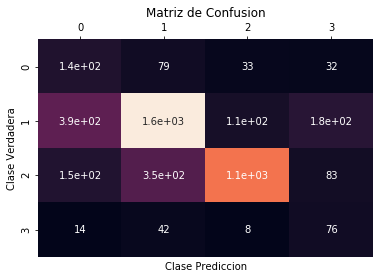

In [0]:
#resultadosEntrenamiento.graficarMatrizConfusion()
resultadosValidacion.graficarMatrizConfusion()